# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.202000,False,-0.913144
1,1.164239,True,5.180507
2,-0.386032,False,0.104766
3,0.449098,False,-0.547419
4,0.112772,True,5.069512
...,...,...,...
995,-1.033002,False,-1.424782
996,-0.455437,False,-0.765626
997,-0.653236,True,3.550977
998,0.077006,False,3.405825


<AxesSubplot: xlabel='v0'>

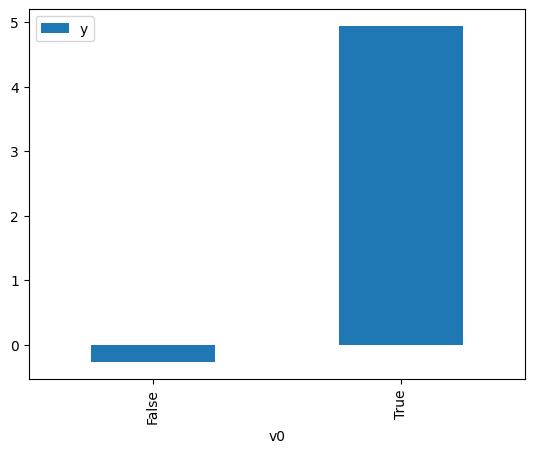

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

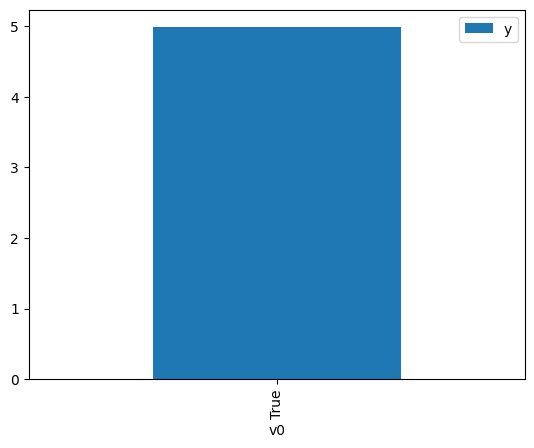

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.059777,False,0.297706,0.586919,1.703814
1,-0.477453,False,-1.265578,0.792234,1.262253
2,-1.448809,False,-2.684420,0.974277,1.026402
3,-0.229418,False,-1.977764,0.679657,1.471329
4,1.604191,False,3.757857,0.027076,36.932873
...,...,...,...,...,...
995,-0.007943,False,-0.642476,0.556934,1.795546
996,-0.013983,False,-0.356504,0.560454,1.784269
997,-1.221803,False,-0.475460,0.956800,1.045150
998,-0.997656,False,0.140287,0.928772,1.076690


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.298860,True,4.588363,0.285707,3.500092
1,1.352179,True,5.765816,0.951938,1.050489
2,-0.580260,True,5.709339,0.170592,5.861927
3,0.328725,True,6.397435,0.638073,1.567220
4,0.603849,True,6.399559,0.771585,1.296034
...,...,...,...,...,...
995,0.553379,True,5.659539,0.749884,1.333540
996,-0.675421,True,3.785424,0.141079,7.088214
997,0.576260,True,4.630885,0.759889,1.315981
998,-0.667866,True,4.592192,0.143257,6.980459


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                              4768.
Date:                Tue, 07 Feb 2023   Prob (F-statistic):                        0.00
Time:                        02:51:25   Log-Likelihood:                         -1429.1
No. Observations:                1000   AIC:                                      2862.
Df Residuals:                     998   BIC:                                      2872.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7548      0.030     25.298      0.000       0.696       0.813
x2             4.9116      0.057     86.021      0.000       4.800       5.024
==============================================================================
Omnibus:                        0.943   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.624   Jarque-Bera (JB):                0.817
Skew:                          -0.018   Prob(JB):                        0.665
Kurtosis:                       3.135   Cond. No.                         2.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""